In [29]:
!pip install tf_keras

**Importing Libraries**

In [30]:
import os
os.environ['TF_USE_LEGACY_KERAS'] = '1'
import io
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, accuracy_score

**Loading the dataset**

**Reading the dataset into a pandas dataframe**

In [31]:
df = pd.read_csv('data.csv')
print(df.columns)
features=df.iloc[:,1:8].values
target=df.iloc[:,-1].values

Index(['Serial No.', 'GRE Score', 'TOEFL Score', 'University Rating', 'SOP',
       'LOR', 'CGPA', 'Research', 'Chance of Admit'],
      dtype='object')


**Test Train Split**


In [32]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42)

**Feature Scaling**

In [33]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test=scaler.transform(X_test)

**Converting the data into Tenserflow tensors**

In [34]:
X_train_tf= tf.constant(X_train, dtype=tf.float32)
X_test_tf = tf.constant(X_test, dtype=tf.float32)
y_train_tf = tf.constant(y_train.reshape(-1,1), dtype=tf.float32)
y_test_tf = tf.constant(y_test.reshape(-1,1), dtype=tf.float32)

**Initializing Weights and Bias as TensorFlow variables and defining the linear regression model and the loss function**

In [35]:
num_features = X_train.shape[1]
W = tf.Variable(tf.random.normal(shape=(num_features, 1)), name='weights')
b = tf.Variable(tf.zeros(shape=(1)), name='bias')

In [36]:
# Define linear regression model
def linear_regression(X):
    return tf.matmul(X, W) + b

In [37]:
# Define the loss function
def mean_squared_error(y_true, y_pred):
    return tf.reduce_mean(tf.square(y_true - y_pred))

In [38]:
# SGD Optimizer
optimizer = tf.optimizers.SGD(learning_rate=0.01)

**Training & Evaluating the model**

In [39]:
def training_func(X, y):
    with tf.GradientTape() as tape:
        predictions = linear_regression(X)
        loss = mean_squared_error(y, predictions)
    gradients = tape.gradient(loss, [W, b])
    optimizer.apply_gradients(zip(gradients, [W, b]))
    return loss

training_loss = []

for epoch in range(1, 1001):
    loss = training_func(X_train_tf, y_train_tf)
    training_loss.append(loss)
    if epoch % 100 == 0:
        print("Epoch {}: Loss: {:.4f}".format(epoch, loss.numpy()))

Epoch 100: Loss: 0.4311
Epoch 200: Loss: 0.1621
Epoch 300: Loss: 0.0781
Epoch 400: Loss: 0.0419
Epoch 500: Loss: 0.0241
Epoch 600: Loss: 0.0147
Epoch 700: Loss: 0.0097
Epoch 800: Loss: 0.0069
Epoch 900: Loss: 0.0054
Epoch 1000: Loss: 0.0046


**Evaluating The Model**

In [40]:
predictions = linear_regression(X_test_tf)
mse = mean_squared_error(y_test_tf, predictions)
print("Mean Squared Error on Testing Data:", mse.numpy())

Mean Squared Error on Testing Data: 0.0058505256


**Training Loss Vs Epochs**

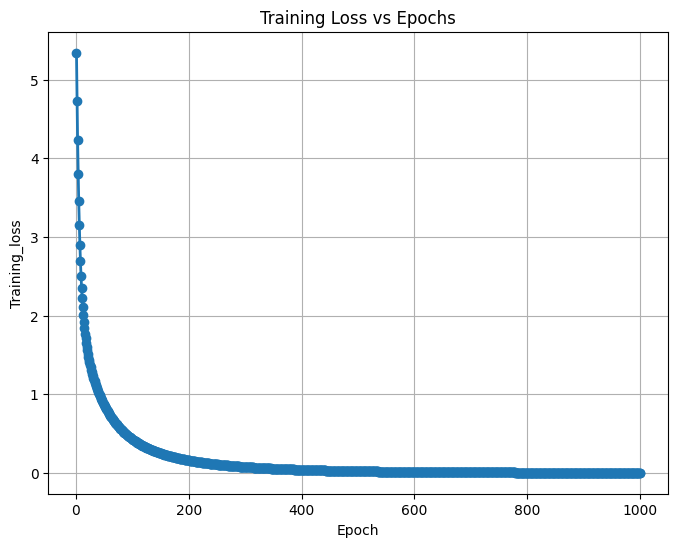

In [41]:
plt.figure(figsize=(8, 6))
plt.plot(range(1, 1001), training_loss, marker='o', linestyle='-', lw = 2)
plt.xlabel('Epoch')
plt.ylabel('Training_loss')
plt.title('Training Loss vs Epochs')
plt.grid(True)
plt.show()

**Plotting Actual vs Predicted Probabilities**

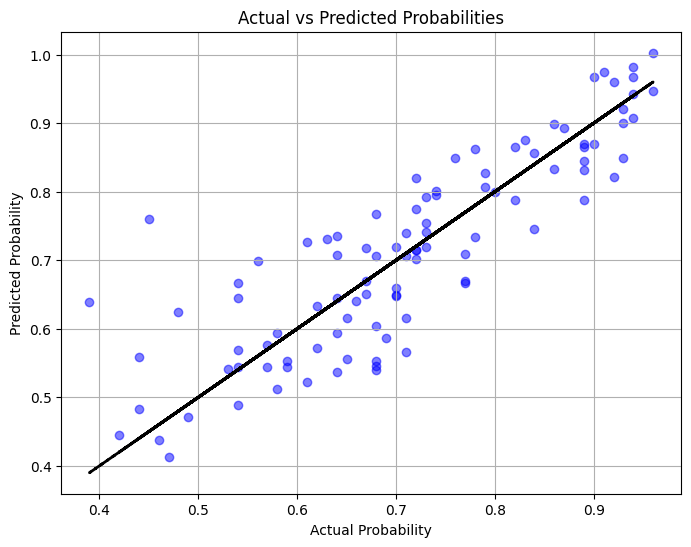

In [42]:
# Plot Actual vs Predicted probabilities
plt.figure(figsize=(8, 6))
plt.scatter(y_test_tf, predictions, color='blue', alpha=0.5)
plt.plot(y_test_tf, y_test_tf, linestyle='--', lw=2, color='black')
plt.xlabel('Actual Probability')
plt.ylabel('Predicted Probability')
plt.title('Actual vs Predicted Probabilities')
plt.grid(True)
plt.show()

**Binning Process and Logistic Regression**

In [43]:
bin_edges = [0.3, 0.5, 0.7, 1.0]
bin_labels = ['Low', 'Medium', 'High']

df['Admit Category'] = pd.cut(df['Chance of Admit'], bins = bin_edges, labels = bin_labels, include_lowest = True)
target_new = df['Admit Category'].values

X_train_new, X_test_new, y_train_new, y_test_new = train_test_split(features, target_new, test_size=0.2, random_state=42)

scaler_new = StandardScaler()
X_train = scaler_new.fit_transform(X_train)
X_test=scaler_new.transform(X_test)

**Encoding**

In [44]:
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()

# Fit label encoder and transform the target values
y_train_encoded = label_encoder.fit_transform(y_train_new)
y_test_encoded = label_encoder.transform(y_test_new)

**Log-Reg Model**

In [45]:
def logistic_regression_model(X_train, y_train, X_test, y_test):
    # Define model parameters
    num_features = X_train.shape[1]
    num_classes = len(np.unique(y_train))
    learning_rate = 0.1
    epochs = 1000
    batch_size = 32


    model = tf.keras.Sequential([
        tf.keras.layers.Dense(num_classes, activation='softmax', input_shape=(num_features,))
    ])

    # Compile the model
    model.compile(optimizer=tf.keras.optimizers.SGD(learning_rate),
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])

    # Train the model
    for epoch in range(epochs):
        # Fit the model for one epoch
        model.fit(X_train, y_train, batch_size=batch_size, epochs=1, verbose=0)

        # Print the loss after every 50 epochs
        if (epoch + 1) % 50 == 0:
            loss, accuracy = model.evaluate(X_train, y_train, verbose=0)
            print(f"Epoch {epoch+1}, Loss: {loss}, Accuracy: {accuracy}")

    # Evaluate the model
    test_loss, test_accuracy = model.evaluate(X_test, y_test)
    print("Test Accuracy:", test_accuracy)

In [46]:
logistic_regression_model(X_train_new, y_train_encoded, X_test_new, y_test_encoded)

Epoch 50, Loss: 1984.957763671875, Accuracy: 0.5950000286102295
Epoch 100, Loss: 2045.6640625, Accuracy: 0.07500000298023224
Epoch 150, Loss: 1268.7386474609375, Accuracy: 0.612500011920929
Epoch 200, Loss: 2524.853759765625, Accuracy: 0.5899999737739563
Epoch 250, Loss: 2213.34228515625, Accuracy: 0.5899999737739563
Epoch 300, Loss: 4057.783447265625, Accuracy: 0.33500000834465027
Epoch 350, Loss: 394.9150390625, Accuracy: 0.6474999785423279
Epoch 400, Loss: 4458.29931640625, Accuracy: 0.33500000834465027
Epoch 450, Loss: 1685.4302978515625, Accuracy: 0.6050000190734863
Epoch 500, Loss: 1784.614990234375, Accuracy: 0.5924999713897705
Epoch 550, Loss: 3614.22216796875, Accuracy: 0.33500000834465027
Epoch 600, Loss: 1603.3231201171875, Accuracy: 0.3474999964237213
Epoch 650, Loss: 1482.4613037109375, Accuracy: 0.5924999713897705
Epoch 700, Loss: 643.1043090820312, Accuracy: 0.6575000286102295
Epoch 750, Loss: 420.2870788574219, Accuracy: 0.5950000286102295
Epoch 800, Loss: 453.812774658

**Impact of Learning Rate on Model's Performance**

In [47]:
learning_rates = [0.2, 0.1, 0.01, 0.001]
epochs = 100

for lr in learning_rates:
  optimizer = tf.optimizers.SGD(learning_rate = lr)
  loss_for_cur_lr = 0;
  for epoch in range(epochs):
    loss = training_func(X_train_tf, y_train_tf)
    if epoch == epochs-1:
      loss_for_cur_lr = loss.numpy()
  predictions = linear_regression(X_test_tf)
  mse = mean_squared_error(y_test_tf, predictions)
  print(f"Learning rate {lr}: Loss = {loss.numpy()} Mean squared error: {mse}")


Learning rate 0.2: Loss = 0.0035265618935227394 Mean squared error: 0.003706695046275854
Learning rate 0.1: Loss = 0.0035265556070953608 Mean squared error: 0.003704757895320654
Learning rate 0.01: Loss = 0.0035265556070953608 Mean squared error: 0.0037047320511192083
Learning rate 0.001: Loss = 0.0035265556070953608 Mean squared error: 0.003704726928845048


**Correlation coefficients & feature selection**

<ipython-input-48-e93691e2810f>:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  correlation_matrix = df.corr()


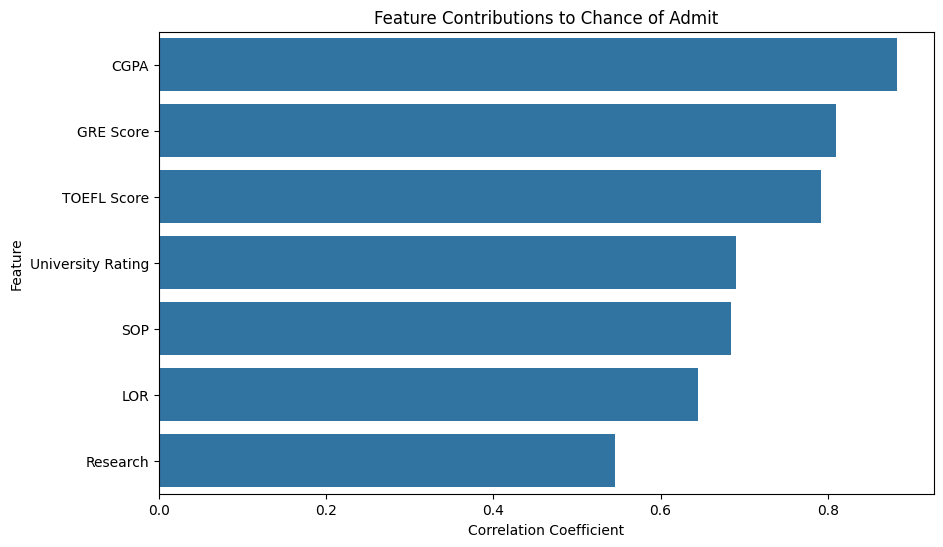

Mean Squared Error: tf.Tensor(0.003983105785984343, shape=(), dtype=float64)
We can clearly see that when we train the model using the features with most contribution to target, the model is much more accurate


In [48]:
correlation_matrix = df.corr()
correlation_with_target = correlation_matrix['Chance of Admit'].drop(['Serial No.', 'Chance of Admit'])
plt.figure(figsize=(10, 6))
sorted_correlation_with_target = correlation_with_target.sort_values(ascending=False)
sns.barplot(x=sorted_correlation_with_target.values, y=sorted_correlation_with_target.index)
plt.title('Feature Contributions to Chance of Admit')
plt.xlabel('Correlation Coefficient')
plt.ylabel('Feature')
plt.show()


top_features = sorted_correlation_with_target.head(4).index.tolist()
A = df[top_features]
B = df['Chance of Admit']

A_train, A_test, B_train, B_test = train_test_split(A, B, test_size=0.2, random_state=42)

model = LinearRegression()
model.fit(A_train, B_train)

B_pred = model.predict(A_test)
mse = mean_squared_error(B_test, B_pred)

print("Mean Squared Error:", mse)

print("We can clearly see that when we train the model using the features with most contribution to target, the model is much more accurate")

**Comparative analysis of Linear Regression and Logistic Regression(Splitting done using k-fold cross-validation)**

In [49]:
from sklearn.model_selection import KFold
from sklearn.linear_model import LinearRegression, LogisticRegression
k = 5  # Set number of folds for k-fold cross-validation
kf = KFold(n_splits=k, shuffle=True, random_state=42)

y_train_binary = (y_train > 0.5).astype(int)
y_test_binary = (y_test > 0.5).astype(int)

target_binary = (target > 0.5).astype(int)

k_folds = 5
kf = KFold(n_splits=k_folds, shuffle=True, random_state=42)

# Initialize lists to store evaluation metrics
linear_regression_mse = []
logistic_regression_accuracy = []

# Perform K-Fold cross-validation
for train_index, test_index in kf.split(scaled_features):
    X_train, X_test = scaled_features[train_index], scaled_features[test_index]
    y_train, y_test = target_binary[train_index], target_binary[test_index]

    # Linear Regression
    linear_reg = LinearRegression()
    linear_reg.fit(X_train, y_train)
    linear_pred = linear_reg.predict(X_test)
    linear_regression_mse.append(mean_squared_error(y_test, linear_pred))

    # Logistic Regression
    logistic_reg = LogisticRegression()
    logistic_reg.fit(X_train, y_train)
    logistic_pred = logistic_reg.predict(X_test)
    logistic_regression_accuracy.append(accuracy_score(y_test, logistic_pred))

# Calculate mean performance metrics
mean_linear_regression_mse = np.mean(linear_regression_mse)
mean_logistic_regression_accuracy = np.mean(logistic_regression_accuracy)

# Print results
print("Mean Squared Error (Linear Regression):", mean_linear_regression_mse)
print("Mean Accuracy (Logistic Regression):", mean_logistic_regression_accuracy)

Mean Squared Error (Linear Regression): 0.059330884988798946
Mean Accuracy (Logistic Regression): 0.944


**Logistic Regression using Sigmoid as an Activation Function**

In [50]:
model = tf.keras.Sequential([tf.keras.layers.Dense(1, activation='sigmoid', input_shape=(X_train.shape[1],))])

model.compile(optimizer='sgd', loss='binary_crossentropy', metrics=['accuracy'])

# Training loop
epochs = 1000
for epoch in range(epochs):
    # Train the model for one epoch
    model.fit(X_train, y_train_binary, epochs=1, verbose=0)

# Evaluate the model on test data
loss, accuracy = model.evaluate(X_test, y_test_binary)
print(f"\nTest Loss: {loss:.4f}, Test Accuracy: {accuracy:.4f}")

4/4 [==============================] - 0s 2ms/step - loss: 0.3149 - accuracy: 0.9100

Test Loss: 0.3149, Test Accuracy: 0.9100
